In [41]:
import gettext
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import mean_squared_error
from snape.make_dataset import make_dataset


In [42]:
# Load the data
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
testID = test['Id']

In [43]:
# View the data as a preview
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [44]:
# Viewing information about the data variables
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [45]:
#Identify the features in which there are more than 30% of the data nulled out
missing_features = []
for ftr in train.columns.values:
    if train[ftr].isnull().sum() > (len(train) // 3.0):
        missing_features.append(ftr)
        print(ftr)

Alley
FireplaceQu
PoolQC
Fence
MiscFeature


In [46]:
train.drop(missing_features, axis=1, inplace=True)
test.drop(missing_features, axis=1, inplace=True)

In [47]:
train.shape

(1460, 76)

<AxesSubplot:>

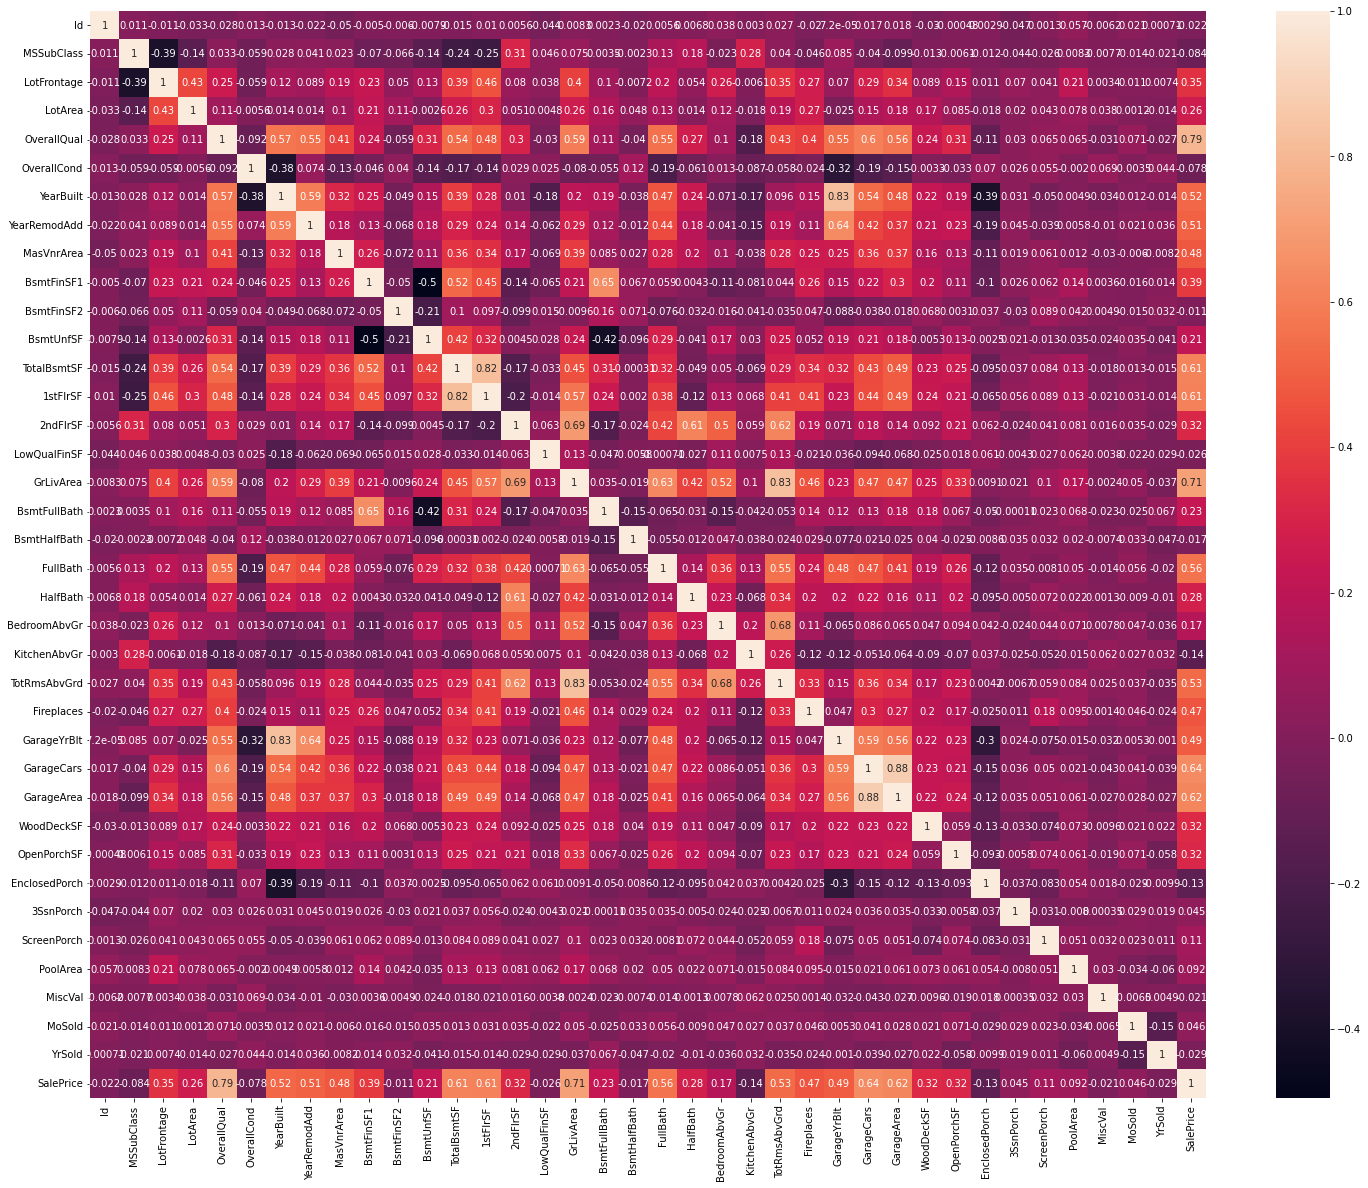

In [48]:
# Look for correlations between the features to prep for removing correlated features
plt.figure(figsize=(25, 20))
sns.heatmap(train.corr(), annot=True)

In [49]:
# Remove features that are highly correlated
cols_to_remove = []
corltn_data = train.corr()
corltn_vals = corltn_data['SalePrice'].sort_values(ascending=False)
corltn_vals = abs(corltn_vals).sort_values(ascending=False)
for col in range(len(corltn_vals)):
    if abs(corltn_vals[col]) < 0.2:
        cols_to_remove.append(corltn_vals.index[col])
        train = train.drop([corltn_vals.index[col]], axis=1)

train.shape

(1460, 61)

In [50]:
cols_to_remove

['BedroomAbvGr',
 'KitchenAbvGr',
 'EnclosedPorch',
 'ScreenPorch',
 'PoolArea',
 'MSSubClass',
 'OverallCond',
 'MoSold',
 '3SsnPorch',
 'YrSold',
 'LowQualFinSF',
 'Id',
 'MiscVal',
 'BsmtHalfBath',
 'BsmtFinSF2']

In [51]:
test.drop(cols_to_remove, inplace=True, axis=1)

In [52]:
# One Hot Encoding of the Variables
onehot_encoded_cols = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
                       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
                       'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType',
                       'SaleCondition']

# Ordinal Encoding of Variables
# Col : Coverage : Mapping
ordinal_encoded_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']

ordinal_encoding_dict = [{'col': 'ExterQual', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}},
                         {'col': 'ExterCond', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}},
                         {'col': 'BsmtQual', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}},
                         {'col': 'BsmtCond', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}},
                         {'col': 'BsmtExposure', 'mapping': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}},
                         {'col': 'BsmtFinType1',
                          'mapping': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}},
                         {'col': 'BsmtFinType2',
                          'mapping': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}},
                         {'col': 'HeatingQC', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}},
                         {'col': 'KitchenQual', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}},
                         {'col': 'GarageQual', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}},
                         {'col': 'GarageCond', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}}]



In [53]:
import category_encoders as ce

ordinal_encoder = ce.OrdinalEncoder(cols=ordinal_encoded_cols, mapping=ordinal_encoding_dict)
onehot_encoder = ce.OneHotEncoder(cols=onehot_encoded_cols)

In [54]:
train.shape

(1460, 61)

In [55]:
test.shape

(1459, 60)

In [56]:
ordinal_encoder.fit(train)

OrdinalEncoder(cols=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond'],
               mapping=[{'col': 'ExterQual',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'ExterCond',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'BsmtQual',
                         'mapping': {'Ex': 5, 'Fa': 2...
                         'mapping': {'ALQ': 5, 'BLQ': 4, 'GLQ': 6, 'LwQ': 2,
                                     'NA': 0, 'Rec': 3, 'Unf': 1}},
                        {'col': 'HeatingQC',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'Kitch

In [57]:
ordinal_encoder.fit(test)

OrdinalEncoder(cols=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond'],
               mapping=[{'col': 'ExterQual',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'ExterCond',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'BsmtQual',
                         'mapping': {'Ex': 5, 'Fa': 2...
                         'mapping': {'ALQ': 5, 'BLQ': 4, 'GLQ': 6, 'LwQ': 2,
                                     'NA': 0, 'Rec': 3, 'Unf': 1}},
                        {'col': 'HeatingQC',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'Kitch

In [58]:
onehot_encoder.fit(train)

OneHotEncoder(cols=['MSZoning', 'Street', 'LotShape', 'LandContour',
                    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                    'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                    'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
                    'Electrical', 'Functional', 'GarageType', 'GarageFinish',
                    'PavedDrive', 'SaleType', 'SaleCondition'])

In [59]:
ordinal_encoder.fit(test)

OrdinalEncoder(cols=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond'],
               mapping=[{'col': 'ExterQual',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'ExterCond',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'BsmtQual',
                         'mapping': {'Ex': 5, 'Fa': 2...
                         'mapping': {'ALQ': 5, 'BLQ': 4, 'GLQ': 6, 'LwQ': 2,
                                     'NA': 0, 'Rec': 3, 'Unf': 1}},
                        {'col': 'HeatingQC',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'Kitch

In [60]:
train = ordinal_encoder.fit_transform(train)
test = ordinal_encoder.fit_transform(test)

In [61]:
train.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice
0,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,2,548,3.0,3.0,Y,0,61,WD,Normal,208500
1,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,2,460,3.0,3.0,Y,298,0,WD,Normal,181500
2,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,2,608,3.0,3.0,Y,0,42,WD,Normal,223500
3,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,3,642,3.0,3.0,Y,0,35,WD,Abnorml,140000
4,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,3,836,3.0,3.0,Y,192,84,WD,Normal,250000


In [62]:
test.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition
0,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,Unf,1.0,730.0,3.0,3.0,Y,140,0,WD,Normal
1,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,Unf,1.0,312.0,3.0,3.0,Y,393,36,WD,Normal
2,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,Fin,2.0,482.0,3.0,3.0,Y,212,34,WD,Normal
3,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,Fin,2.0,470.0,3.0,3.0,Y,360,36,WD,Normal
4,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,...,RFn,2.0,506.0,3.0,3.0,Y,0,82,WD,Normal


In [63]:
train = onehot_encoder.fit_transform(train)
test = onehot_encoder.fit_transform(test)

In [64]:
train.head()

,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,LotFrontage,LotArea,Street_1,Street_2,LotShape_1,...,SaleType_7,SaleType_8,SaleType_9,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6,SalePrice
0,1,0,0,0,0,65.0,8450,1,0,1,...,0,0,0,1,0,0,0,0,0,208500
1,1,0,0,0,0,80.0,9600,1,0,1,...,0,0,0,1,0,0,0,0,0,181500
2,1,0,0,0,0,68.0,11250,1,0,0,...,0,0,0,1,0,0,0,0,0,223500
3,1,0,0,0,0,60.0,9550,1,0,0,...,0,0,0,0,1,0,0,0,0,140000
4,1,0,0,0,0,84.0,14260,1,0,0,...,0,0,0,1,0,0,0,0,0,250000


In [65]:
test.head()

,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,MSZoning_6,LotFrontage,LotArea,Street_1,Street_2,...,SaleType_7,SaleType_8,SaleType_9,SaleType_10,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6
0,1,0,0,0,0,0,80.0,11622,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,81.0,14267,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,74.0,13830,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,78.0,9978,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,43.0,5005,1,0,...,0,0,0,0,1,0,0,0,0,0


In [66]:
x = train.drop(['SalePrice'], axis=1)
# Fill Remaining Nan Values With 0
x = x.fillna(0)
y = train['SalePrice']

In [67]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, random_state=42)

In [68]:
x_train

,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,LotFrontage,LotArea,Street_1,Street_2,LotShape_1,...,SaleType_6,SaleType_7,SaleType_8,SaleType_9,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6
615,1,0,0,0,0,80.0,8800,1,0,1,...,0,0,0,0,0,1,0,0,0,0
613,1,0,0,0,0,70.0,8402,1,0,1,...,0,0,0,0,0,0,1,0,0,0
1303,1,0,0,0,0,73.0,8688,1,0,1,...,0,0,0,0,1,0,0,0,0,0
486,1,0,0,0,0,79.0,10289,1,0,1,...,0,0,0,0,1,0,0,0,0,0
561,1,0,0,0,0,77.0,10010,1,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1,0,0,0,0,78.0,9317,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1130,1,0,0,0,0,65.0,7804,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1294,1,0,0,0,0,60.0,8172,1,0,1,...,0,0,0,0,1,0,0,0,0,0
860,1,0,0,0,0,55.0,7642,1,0,1,...,0,0,0,0,1,0,0,0,0,0


In [69]:
y_train

615     137500
613     147000
1303    232000
486     156000
561     170000
         ...  
1095    176432
1130    135000
1294    115000
860     189950
1126    174000
Name: SalePrice, Length: 978, dtype: int64

In [70]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(x_train, y_train)

In [71]:
def print_rmse_score_by_model(model_name, model):
    print("{}:".format(model_name))
    print("train_score:", model.score(x_train, y_train))
    print("test_score:", model.score(x_val, y_val))
    print("train RMSE:", np.sqrt(mean_squared_error(np.log(y_train), np.log(model.predict(x_train)))))
    print("test RMSE:", np.sqrt(mean_squared_error(np.log(y_val), np.log(model.predict(x_val)))))
    print("------------------------------")

In [72]:
print_rmse_score_by_model("Linear Regression", lr)

Linear Regression:
train_score: 0.9185400292960494
test_score: 0.869772196046122
train RMSE: 0.13747380573597806
test RMSE: 0.23420829379370364
------------------------------


In [73]:
def cost_function(X, y, w, b):
    """
    Parameters:
    X: features
    y: target values
    w: weights
    b: bias

    Returns:
    cost: cost with current weights and bias
    """
    cost = np.sum((((X.dot(w) + b) - y) ** 2) / (2*len(y)))
    return cost

In [74]:
def gradient_descent_function(X, y, w, b, alpha=0.01, epochs=1000):
    """
    Parameters:
    X: features
    y: target values
    w: initial weights
    b: initial bias
    alpha: learning rate
    epochs: number of iterations

    Returns:
    costs: cost per epoch
    w: finalised weights
    b: finalised bias
    """
    m = len(y)
    costs = [0] * epochs

    for epoch in range(epochs):
        # Calculate the value -- Forward Propagation
        z = X.dot(w) + b

        # Calculate the losses
        loss = z - y

        # Calculate gradient descent
        weight_gradient = X.T.dot(loss) / m
        bias_gradient = np.sum(loss) / m

        # Update weights and bias
        w = w - alpha*weight_gradient
        b = b - alpha*bias_gradient

        # Store current lost
        cost = cost_function(X, y, w, b)
        costs[epoch] = cost

    return w, b, costs

In [75]:
# Initial random weights
w = np.random.randn(x_train.shape[1])
# Initial bias
b = 1
weights, bias, costs = gradient_descent_function(x_train, y_train, w, b, epochs=2500);

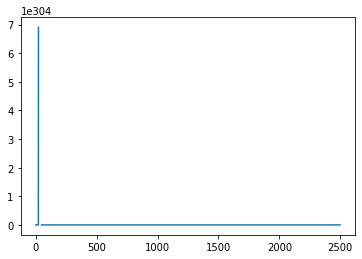

In [76]:
plt.plot(costs)
plt.show()

In [77]:
def predict(X, w,b):
    return X.dot(w) + b

In [78]:
def r2score(y_pred, y):
    """
    Parameters:
    y_pred: predicted values
    y: actual values

    Returns:
    r2: r2 score
    """
    rss = np.sum((y_pred - y) ** 2)
    tss = np.sum((y-y.mean()) ** 2)

    r2 = 1 - (rss / tss)
    return r2

In [79]:
y_pred = predict(x_val, weights, bias)
r2 = r2score(y_pred, y_val)
print(r2)

1.0
